# imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix

In [3]:
train_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

## description of the data

In [4]:
train_df.shape

(617, 58)

- We have 617 rows and 58 features (including the target)

In [5]:
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

- Here `EJ` is the categorical feature and `Class` is the target variable

- We don't know exactly what the feature `EJ` means, hence let's convert it to a numerical feature by using `LabelEncoder`

In [7]:
# Create a OneHotEncoder object
one_hot_encoder = OneHotEncoder(drop='first')

train_df['EJ'] = one_hot_encoder.fit_transform(train_df[['EJ']]).toarray()
test_df['EJ'] = one_hot_encoder.fit_transform(test_df[['EJ']]).toarray()


## Missing values

In [8]:
# print % of the columns with missing values
print('Train data missing values:')
print(train_df.isnull().sum()[train_df.isnull().sum() > 0]/len(train_df)*100)

Train data missing values:
BQ    9.724473
CB    0.324149
CC    0.486224
DU    0.162075
EL    9.724473
FC    0.162075
FL    0.162075
FS    0.324149
GL    0.162075
dtype: float64


- Approx 10% data is missing in BQ and EL classes and rest of the classes have very less missing values.

- As most of the classes have 1-2 missing values, we can impute them with median.

In [9]:
missing_classes = train_df.isnull().sum()[train_df.isnull().sum() > 0].index

In [10]:
for i in missing_classes:
    if i not in ["BQ", "EL"]:
        # fill missing values with the median of the column
        train_df[i].fillna(train_df[i].median(), inplace=True)

In [11]:
print('Train data missing values:')
print(train_df.isnull().sum()[train_df.isnull().sum() > 0]/len(train_df)*100)

Train data missing values:
BQ    9.724473
EL    9.724473
dtype: float64


- As BQ and EL have 10% missing values, we can impute them with KNN imputer.

In [12]:
# Separate the target from the features
y_train = train_df['Class']
X_train = train_df.drop('Class', axis=1)
y_train = train_df['Class']

X_test = test_df

# Drop the id column
X_train.drop('Id', axis=1, inplace=True)
# saving the ids for future submission use
ids = X_test["Id"]
X_test.drop('Id', axis=1, inplace=True)

In [13]:
from sklearn.impute import KNNImputer

# create the KNN imputer object
imputer = KNNImputer(n_neighbors=5)

# fit and transform the dataset
X_train_ = imputer.fit_transform(X_train)

# print the imputed dataset
X_train_

array([[2.09377000e-01, 3.10903329e+03, 8.52001470e+01, ...,
        2.21362290e+01, 6.98349440e+01, 1.20342857e-01],
       [1.45282000e-01, 9.78764160e+02, 8.52001470e+01, ...,
        2.91354300e+01, 3.21319960e+01, 2.19780000e+01],
       [4.70030000e-01, 2.63510654e+03, 8.52001470e+01, ...,
        2.80228510e+01, 3.51926760e+01, 1.96941176e-01],
       ...,
       [4.27300000e-01, 2.45910720e+03, 1.30138587e+02, ...,
        2.61660720e+01, 1.19559420e+02, 2.19780000e+01],
       [3.63205000e-01, 1.26353524e+03, 8.52001470e+01, ...,
        2.51167500e+01, 3.71551120e+01, 1.84621622e-01],
       [4.82849000e-01, 2.67253426e+03, 5.46663930e+02, ...,
        4.57459740e+01, 1.14842372e+02, 2.19780000e+01]])

- Now all the missing values are filled/ imputed.

## One-hot encoding and scaling

In [14]:
train_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.429301,3.533905,0.420947,20.724856,131.714987,14679.595398,31.489716,50.584437,8.517682,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.487330,50.181948,1.303281,9.991907,144.181524,19352.959387,9.864239,36.266251,10.323895,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124414,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.237329,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


- Here the scale of some features is very large and some are very small. So we need to scale the data, specially for the algorithms which are distance based.

In [15]:
# Standardize the data
scaler = StandardScaler()

X_train_ = scaler.fit_transform(X_train_)
X_test_ = scaler.transform(X_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Visualization

In [16]:
# drop the Id
train_df.drop('Id', axis=1, inplace=True)

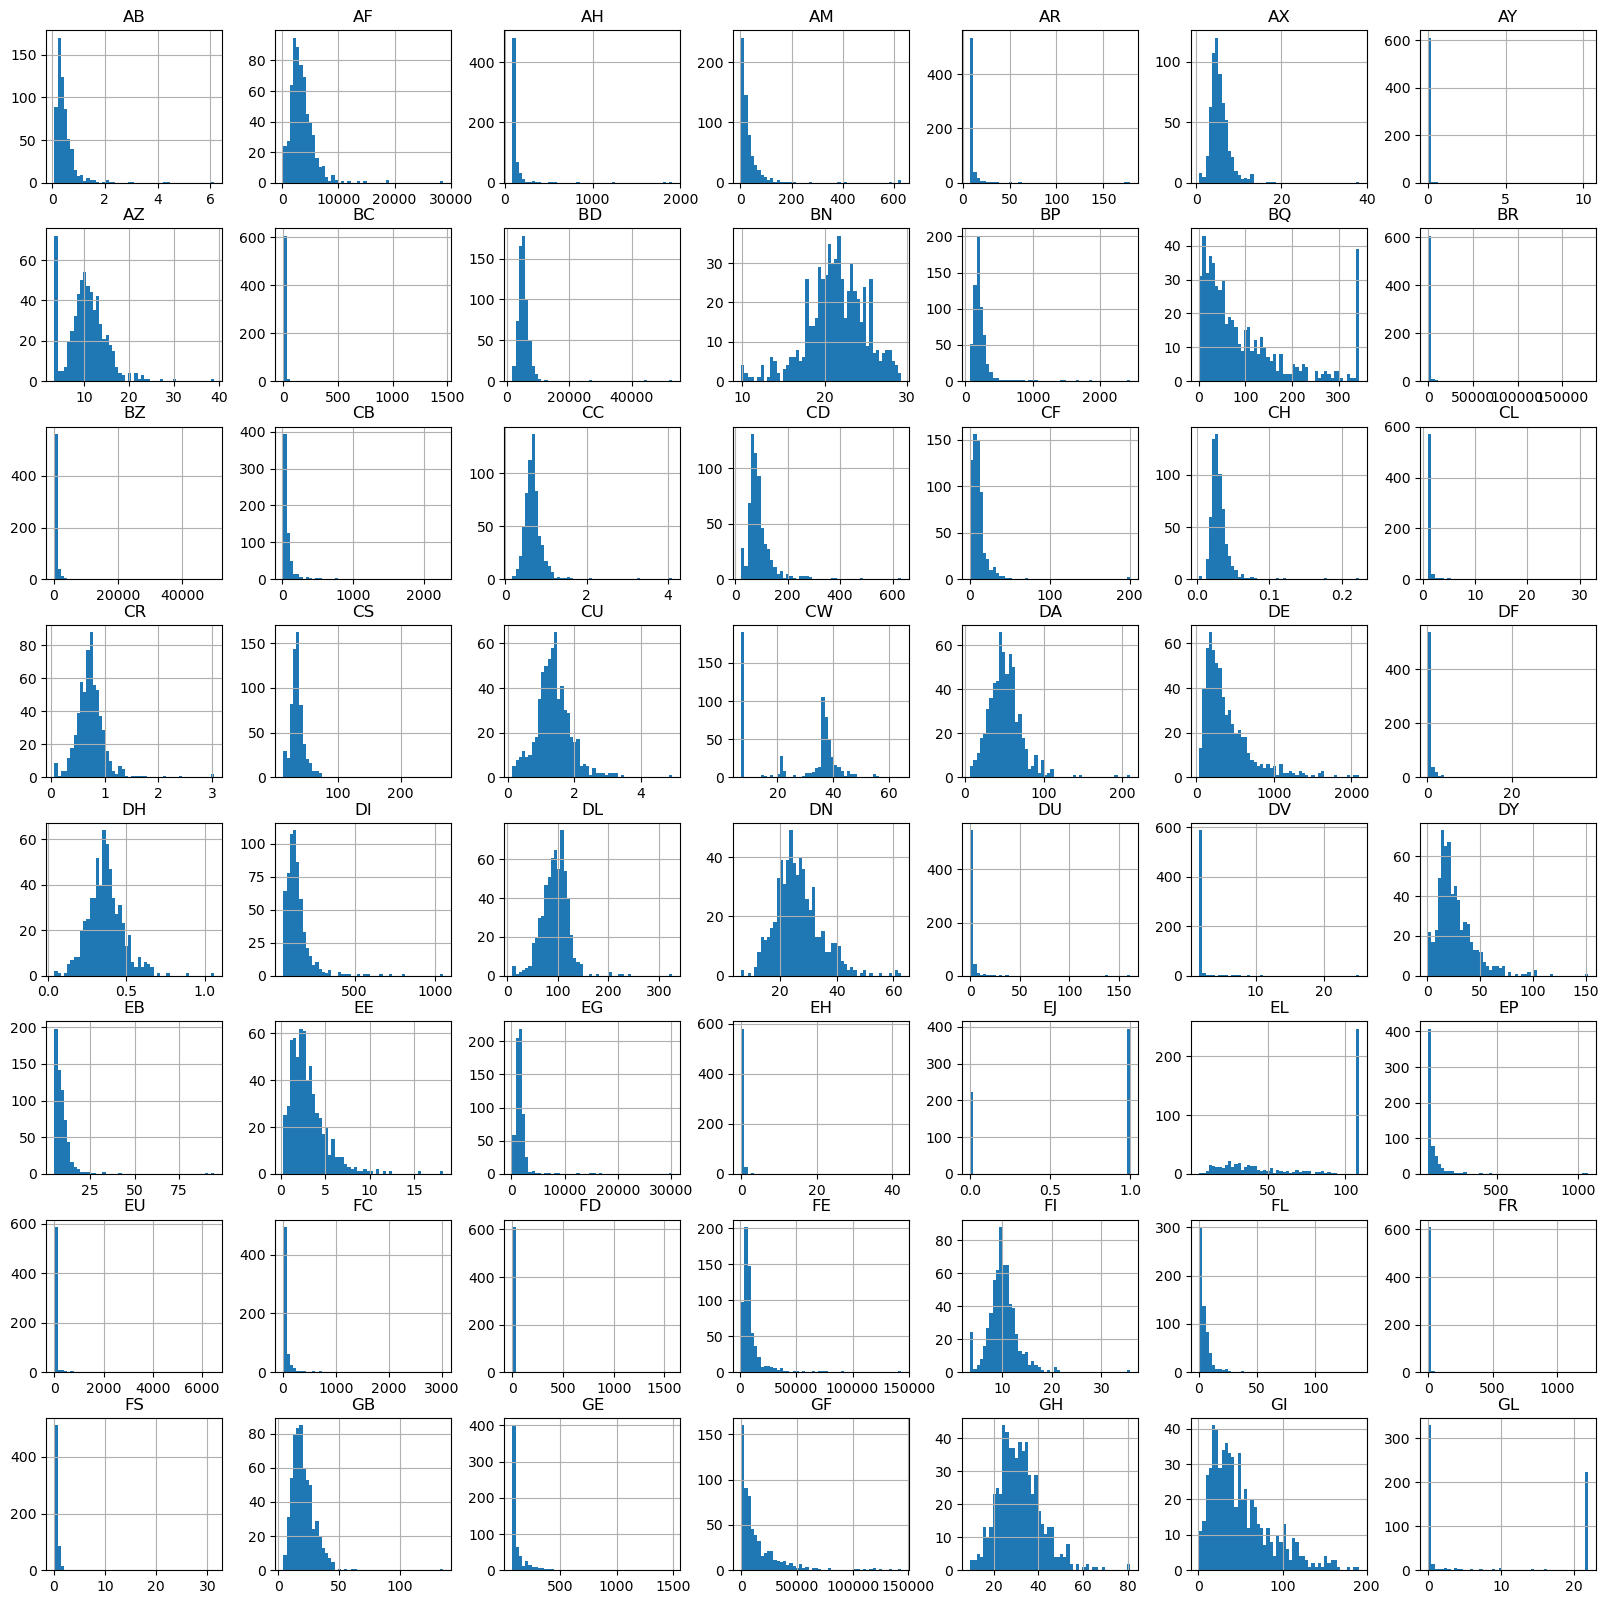

In [17]:

train_df.drop(["Class"], axis=1).hist(figsize=(20, 20), bins=50, legend = False);

- Here we can see that the data is not normally distributed.
- We will normalize the data using `StandardScaler`

## `Class` distribution

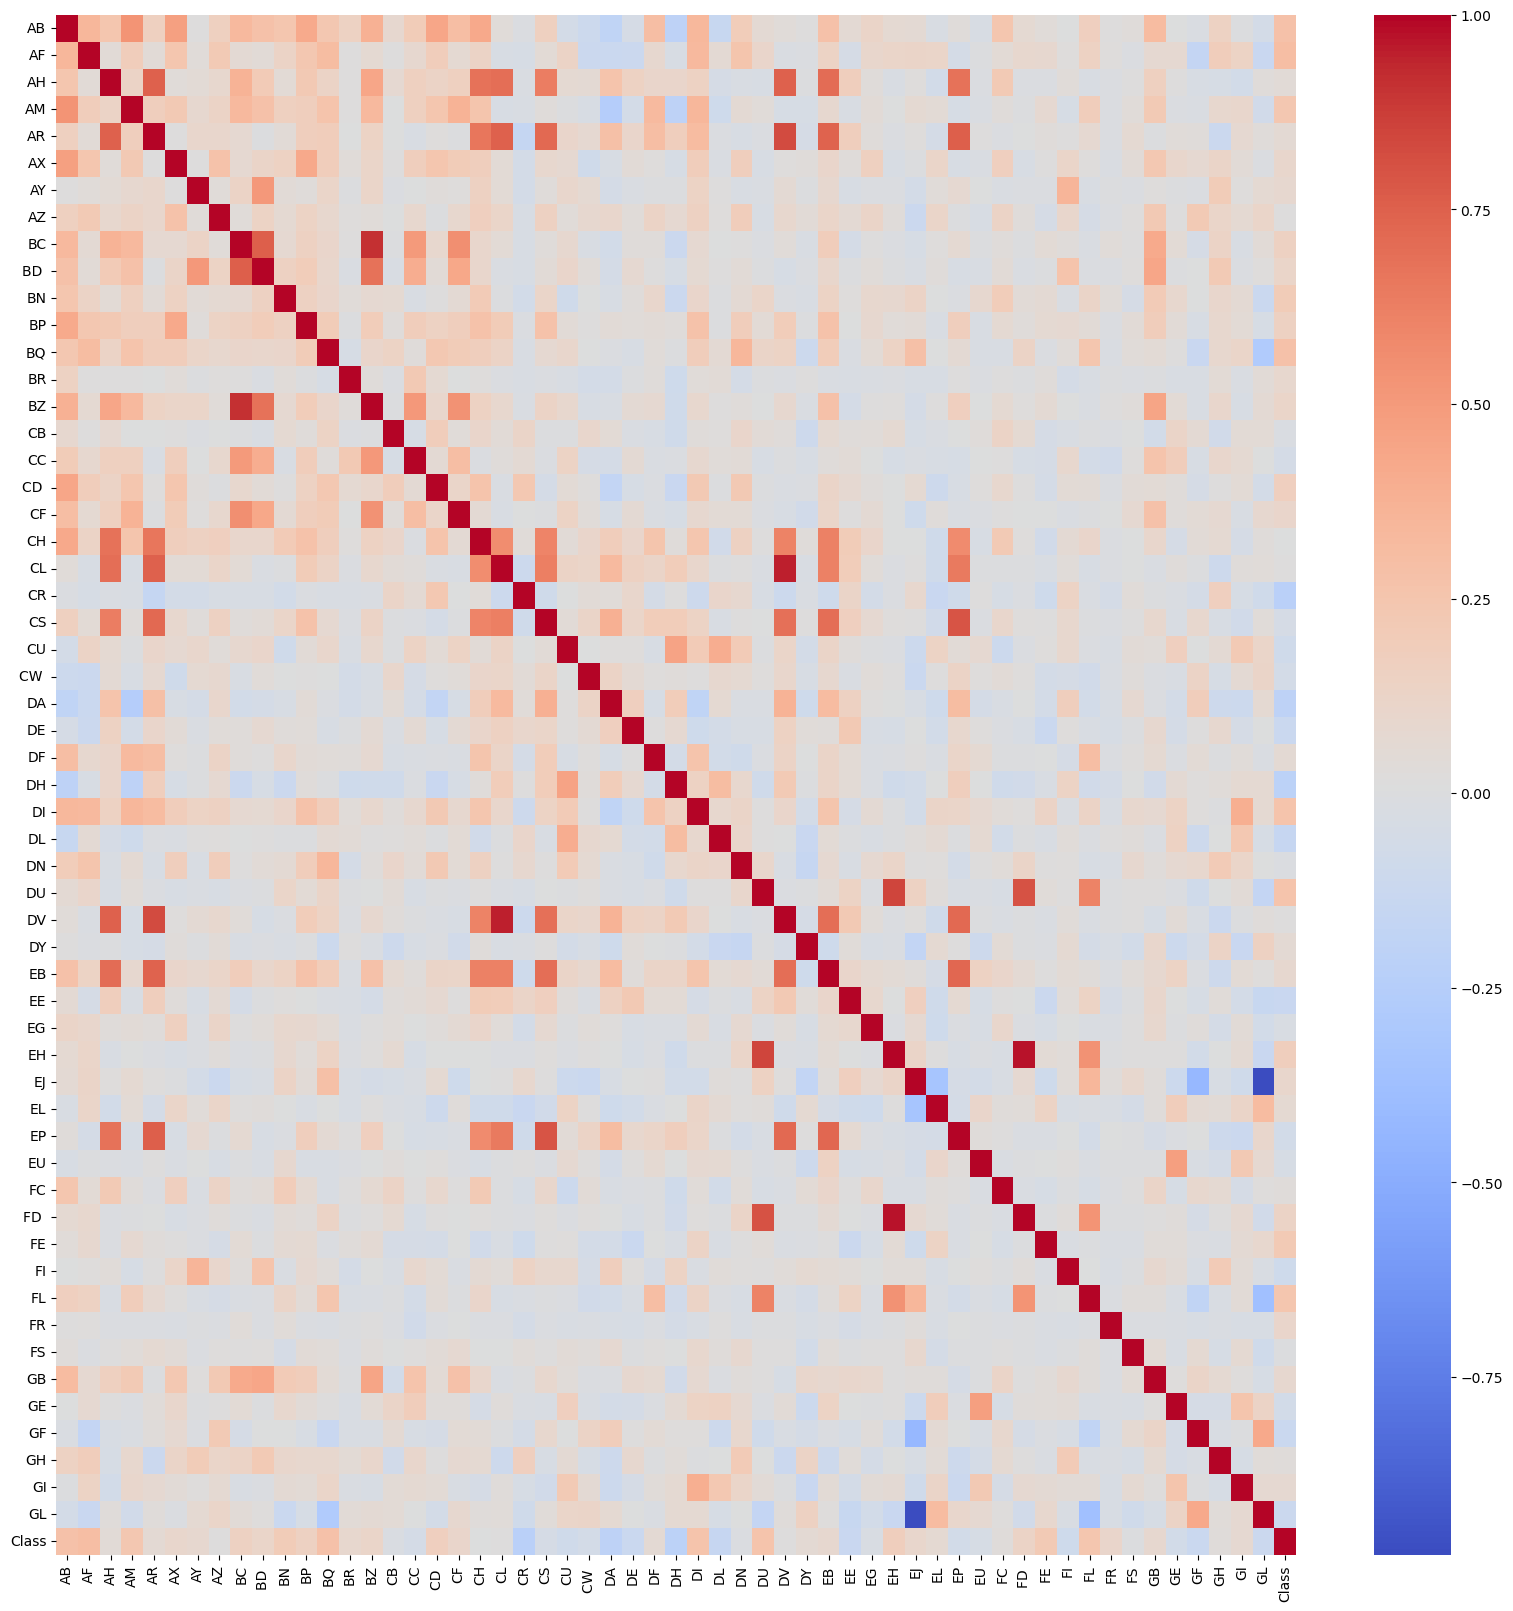

In [18]:
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.corr(), cmap='coolwarm');


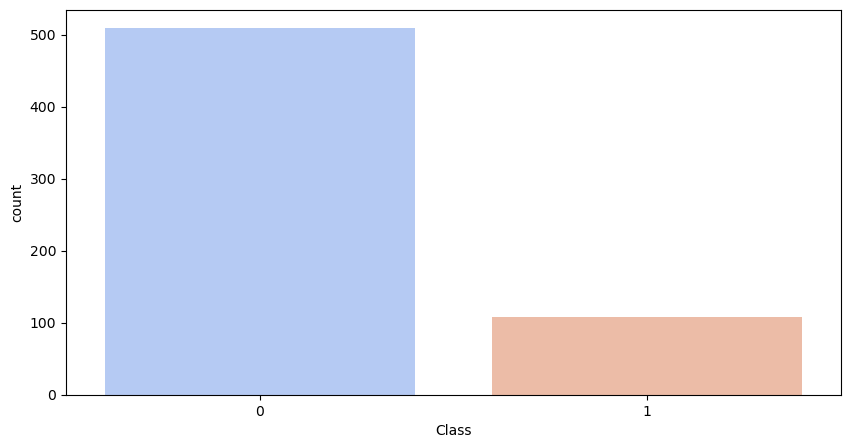

In [19]:
# histogram of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x='Class', data=train_df, palette='coolwarm');


- Data is highly imbalanced. We will use `Class Weights` to handle this.

# Training

In [20]:
# test dataset is X_test_

## Helper functions

In [21]:
# import roc_curve and auc
from sklearn.metrics import roc_curve, auc

def train_model(X_train, y_train, X_test, y_test, model):
    """
    This function trains a model and prints the accuracy score for both the train and test sets
    """
    model.fit(X_train, y_train)
    print('Train accuracy score: ', model.score(X_train, y_train))
    print('Test accuracy score: ', model.score(X_test, y_test))

def plot_confusion_matrix(X_train, y_train, X_test, y_test, model):
    """
    This function plots the confusion matrix for both the train and test sets
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(confusion_matrix(y_train, model.predict(X_train)), annot=True, fmt='d', ax=ax[0])
    ax[0].set_title('Train Confusion Matrix')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')
    sns.heatmap(
        confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d', ax=ax[1])
    ax[1].set_title('Test Confusion Matrix')
    ax[1].set_xlabel('Predicted Label')
    ax[1].set_ylabel('True Label')
    plt.tight_layout()
    

def plot_roc_curve(X_train, y_train, X_test, y_test, model):
    """
    This function plots the roc curve for both the train and test sets
    """
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    ax[0].plot(fpr, tpr, label='ROC Curve')
    ax[0].set_title('Train ROC Curve')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].legend()
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    ax[1].plot(fpr, tpr, label='ROC Curve')
    ax[1].set_title('Test ROC Curve')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].legend()
    plt.tight_layout()
    

## Train-test split

In [22]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X_train_, y_train, test_size=0.2, random_state=42)

## Logistic Regression

In [23]:
# import the LogisticRegression class
from sklearn.linear_model import LogisticRegression

# create the LogisticRegression object, giving the class_weight parameter
lg = LogisticRegression(class_weight='balanced')

# train the model
train_model(train_X, train_Y, test_X, test_Y, lg)

Train accuracy score:  0.9148073022312373
Test accuracy score:  0.9112903225806451


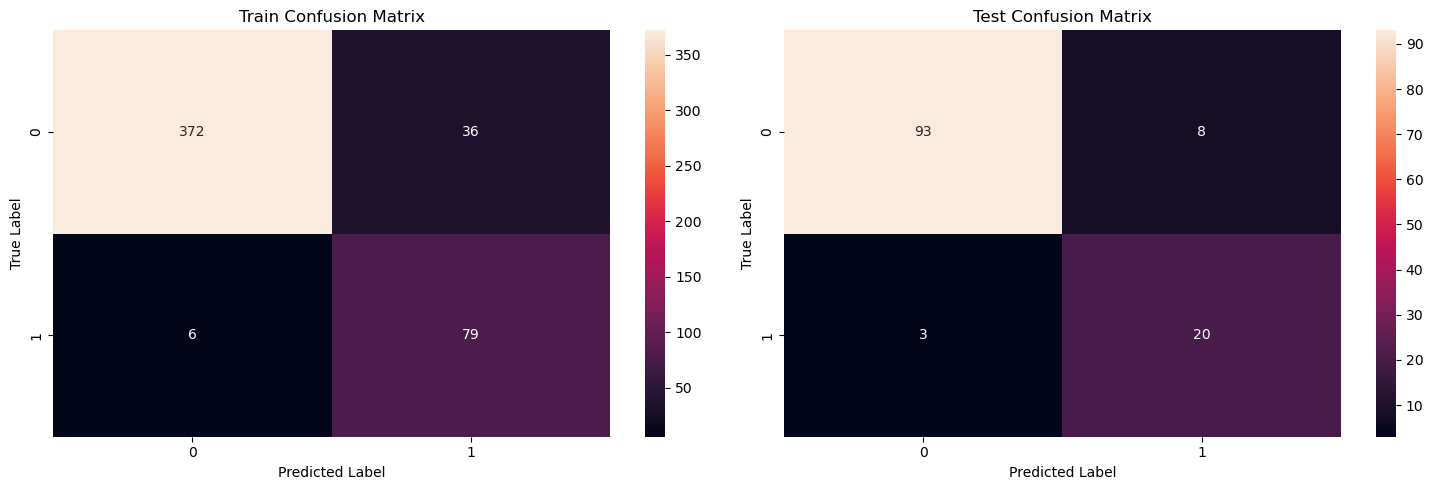

In [24]:
plot_confusion_matrix(train_X, train_Y, test_X, test_Y, lg)

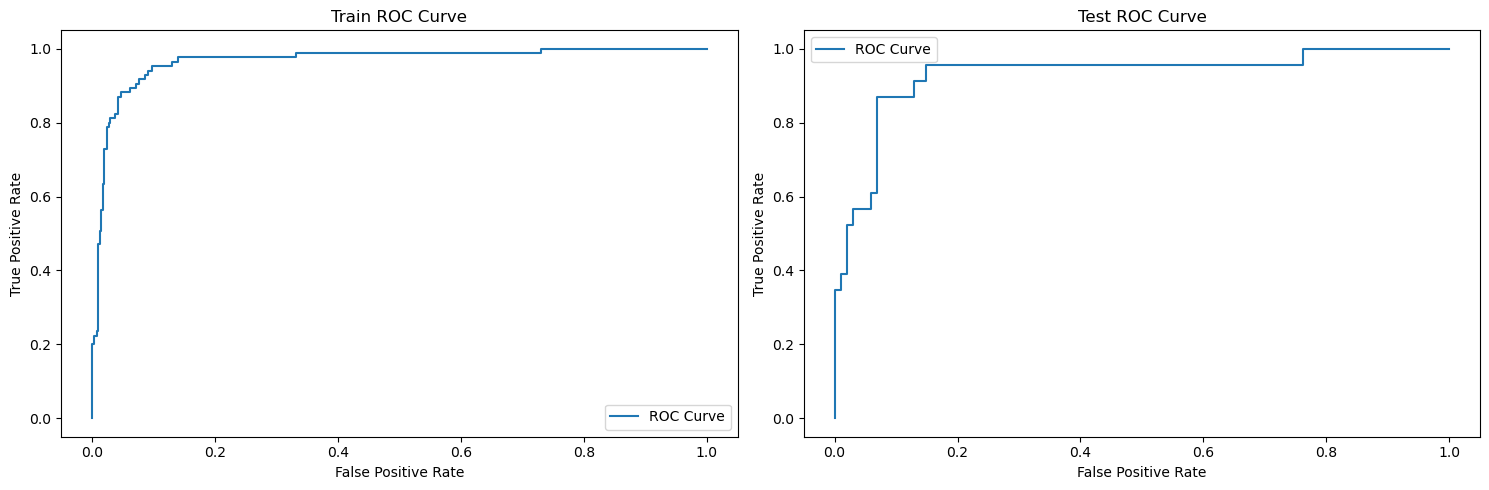

In [25]:
plot_roc_curve(train_X, train_Y, test_X, test_Y, lg)

- Here we can see `AUC` is nearly 1.0, which is good.

## SVM

In [26]:
# import the SVC class
from sklearn.svm import SVC

### Kernel `rbf`

In [27]:
svm_rbf = SVC(kernel='rbf', class_weight='balanced', probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_rbf)

Train accuracy score:  0.9614604462474645
Test accuracy score:  0.8790322580645161


- Clearly, `rbf` kernel is overfitting the data.

### Kernel `linear`

In [28]:
svm_linear = SVC(kernel='linear', class_weight='balanced', probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_linear)

Train accuracy score:  0.9168356997971603
Test accuracy score:  0.9274193548387096


- `linear` kernel is performing better than `rbf` kernel.

### Kernel `poly`

In [29]:
svm_poly = SVC(kernel='poly', class_weight='balanced', probability=True)

# train the model
train_model(train_X, train_Y, test_X, test_Y, svm_poly)

Train accuracy score:  0.922920892494929
Test accuracy score:  0.8548387096774194


- `poly` kernel is also overfitting the data.

## Decision Tree

In [30]:
# import the DecisionTreeClassifier class
from sklearn.tree import DecisionTreeClassifier

# create the DecisionTreeClassifier object, giving the class_weight parameter
dt = DecisionTreeClassifier(class_weight='balanced')

# train the model
train_model(train_X, train_Y, test_X, test_Y, dt)

Train accuracy score:  1.0
Test accuracy score:  0.9193548387096774


- This is also overfitting the data.

### Random Forest

In [31]:
# import the RandomForestClassifier class
from sklearn.ensemble import RandomForestClassifier

# create the RandomForestClassifier object, giving the class_weight parameter
rf = RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=100, min_samples_split=4, min_samples_leaf=1)


# train the model
train_model(train_X, train_Y, test_X, test_Y, rf)

Train accuracy score:  0.9817444219066938
Test accuracy score:  0.9516129032258065


- This is also overfitting the data.

## XGBoost

In [32]:
# import the XGBClassifier class
from xgboost import XGBClassifier

# create the XGBClassifier object, giving the class_weight parameter
xgb = XGBClassifier(scale_pos_weight=3, max_depth=3, n_estimators=60, min_child_weight=20)

# train the model
train_model(train_X, train_Y, test_X, test_Y, xgb)

Train accuracy score:  0.9716024340770791
Test accuracy score:  0.9516129032258065


- This is also overfitting the data.

## CatBoost

In [33]:
# import the CatBoostClassifier class
from catboost import CatBoostClassifier

# create the CatBoostClassifier object, giving the class_weight parameter
cat = CatBoostClassifier(class_weights=[1, 3], max_depth=3, n_estimators=40)

# train the model
train_model(train_X, train_Y, test_X, test_Y, cat)

Learning rate set to 0.145778
0:	learn: 0.6338763	total: 57.4ms	remaining: 2.24s
1:	learn: 0.5620073	total: 59.8ms	remaining: 1.14s
2:	learn: 0.5177556	total: 62ms	remaining: 764ms
3:	learn: 0.4729621	total: 64ms	remaining: 576ms
4:	learn: 0.4473874	total: 66ms	remaining: 462ms
5:	learn: 0.4132963	total: 68.3ms	remaining: 387ms
6:	learn: 0.3917270	total: 70.4ms	remaining: 332ms
7:	learn: 0.3610786	total: 72.6ms	remaining: 291ms
8:	learn: 0.3476083	total: 75ms	remaining: 258ms
9:	learn: 0.3385253	total: 77.2ms	remaining: 232ms
10:	learn: 0.3271233	total: 79.6ms	remaining: 210ms
11:	learn: 0.3180774	total: 81.9ms	remaining: 191ms
12:	learn: 0.3127161	total: 84.4ms	remaining: 175ms
13:	learn: 0.2991284	total: 86.7ms	remaining: 161ms
14:	learn: 0.2776669	total: 89ms	remaining: 148ms
15:	learn: 0.2667865	total: 91.1ms	remaining: 137ms
16:	learn: 0.2589762	total: 93.5ms	remaining: 127ms
17:	learn: 0.2528425	total: 95.8ms	remaining: 117ms
18:	learn: 0.2454713	total: 97.9ms	remaining: 108ms
19

## Let's try to make the Ensemble

- Weights to each model will be given according to their performance on the test data.

In [34]:
# import the EnsembleVoteClassifier class
from sklearn.ensemble import VotingClassifier

# create the EnsembleVoteClassifier object, giving the class_weight parameter
vc = VotingClassifier(estimators=[('lg', lg), ('svm_linear', svm_linear), ('dt', dt), ('rf', rf), ('xgb', xgb), ('cat', cat)], voting='soft', weights=[1, 2, 1, 0.95, 1.4, 1.2])

# train the model
train_model(train_X, train_Y, test_X, test_Y, vc)

Learning rate set to 0.145778
0:	learn: 0.6338763	total: 3.43ms	remaining: 134ms
1:	learn: 0.5620073	total: 5.71ms	remaining: 109ms
2:	learn: 0.5177556	total: 8.2ms	remaining: 101ms
3:	learn: 0.4729621	total: 10.5ms	remaining: 94.9ms
4:	learn: 0.4473874	total: 12.7ms	remaining: 88.9ms
5:	learn: 0.4132963	total: 14.9ms	remaining: 84.2ms
6:	learn: 0.3917270	total: 17.1ms	remaining: 80.6ms
7:	learn: 0.3610786	total: 19.3ms	remaining: 77ms
8:	learn: 0.3476083	total: 21.5ms	remaining: 74.1ms
9:	learn: 0.3385253	total: 23.6ms	remaining: 70.9ms
10:	learn: 0.3271233	total: 25.8ms	remaining: 68ms
11:	learn: 0.3180774	total: 28ms	remaining: 65.4ms
12:	learn: 0.3127161	total: 30.3ms	remaining: 63ms
13:	learn: 0.2991284	total: 32.6ms	remaining: 60.6ms
14:	learn: 0.2776669	total: 34.8ms	remaining: 58.1ms
15:	learn: 0.2667865	total: 37ms	remaining: 55.6ms
16:	learn: 0.2589762	total: 39.3ms	remaining: 53.2ms
17:	learn: 0.2528425	total: 41.5ms	remaining: 50.7ms
18:	learn: 0.2454713	total: 44.1ms	remai

In [35]:
# Training the VC on whole dataset and predicting on test dataset
vc_final = VotingClassifier(estimators=[('lg', lg), ('svm_linear', svm_linear), ('dt', dt), ('rf', rf), ('xgb', xgb), ('cat', cat)], voting='soft', weights=[1, 2, 1, 0.95, 1.4, 1.2])
vc_final.fit(X_train_, y_train)

Learning rate set to 0.160434
0:	learn: 0.6022004	total: 3.42ms	remaining: 133ms
1:	learn: 0.5401737	total: 5.5ms	remaining: 105ms
2:	learn: 0.5215244	total: 7.7ms	remaining: 94.9ms
3:	learn: 0.4819406	total: 9.84ms	remaining: 88.6ms
4:	learn: 0.4495480	total: 12.2ms	remaining: 85.6ms
5:	learn: 0.4101594	total: 14.8ms	remaining: 83.6ms
6:	learn: 0.3922625	total: 17.1ms	remaining: 80.5ms
7:	learn: 0.3575233	total: 19.5ms	remaining: 78.1ms
8:	learn: 0.3494972	total: 21.7ms	remaining: 74.7ms
9:	learn: 0.3360694	total: 24.6ms	remaining: 73.7ms
10:	learn: 0.3233142	total: 27.1ms	remaining: 71.5ms
11:	learn: 0.3127073	total: 29.7ms	remaining: 69.4ms
12:	learn: 0.3050674	total: 32.2ms	remaining: 66.8ms
13:	learn: 0.2981379	total: 34.6ms	remaining: 64.2ms
14:	learn: 0.2880465	total: 37ms	remaining: 61.7ms
15:	learn: 0.2779196	total: 39.5ms	remaining: 59.3ms
16:	learn: 0.2678124	total: 41.9ms	remaining: 56.7ms
17:	learn: 0.2619498	total: 44.4ms	remaining: 54.2ms
18:	learn: 0.2561341	total: 46.7

VotingClassifier(estimators=[('lg',
                              LogisticRegression(class_weight='balanced')),
                             ('svm_linear',
                              SVC(class_weight='balanced', kernel='linear',
                                  probability=True)),
                             ('dt',
                              DecisionTreeClassifier(class_weight='balanced')),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=5,
                                                     min_samples_split=4)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            c...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=20, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=60, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7b1440753220>)],
                 voting='soft', weights=[1, 2, 1, 0.95, 1.4, 1.2])

# Predictions

In [36]:
# Predicting on test dataset
y_pred = vc_final.predict_proba(X_test_)

In [37]:
y_pred[:, 1] = np.maximum(np.minimum(y_pred[:, 1], 1-1e-15), 1e-15)
y_pred[:, 0] = np.maximum(np.minimum(y_pred[:, 0], 1-1e-15), 1e-15)

In [38]:
# y_pred

In [39]:
submission = pd.DataFrame({'Id': ids, 'class_0': y_pred[:, 0], 'class_1': y_pred[:, 1]})

In [40]:
submission.to_csv('submission.csv', index=False)